In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import layers.nn as nn
import layers.conv_nn as cnn
import metrics.metrics as m

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [4]:
data = pd.read_csv("./docklad/digit-recognizer/train.csv")
data.head(5)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


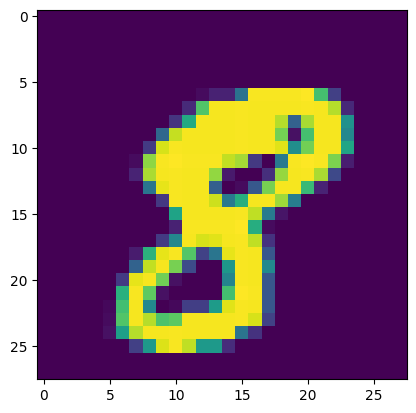

In [5]:
data_numpy = data.to_numpy()
plt.imshow(data_numpy[10][1:].reshape(28, 28))


In [6]:
print(data.shape)

(42000, 785)


In [7]:


X = data.drop(columns=["label"])
y = data["label"]

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.8, random_state=42)
y_train = pd.DataFrame({'class': y_train.values})
y_validate = pd.DataFrame({'class': y_validate.values})


In [8]:
y_train

,class
0,6
1,5
2,3
3,4
4,7
...,...
33595,9
33596,9
33597,2
33598,6


In [9]:
ohe = OneHotEncoder()


def preprocess(X, y, ohe: OneHotEncoder, train=True):
    if train:
        ohe.fit(y)

    y_encod = ohe.transform(y).toarray()

    return np.reshape(X.to_numpy(), newshape=(y_encod.shape[0], 1, 28, 28)), y_encod

In [10]:

X_np_train, y_np_train = preprocess(X_train, y_train, ohe, True)

In [11]:
y_np_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [12]:
model = nn.Model([
    cnn.Conv(1, 6, (5, 5), pad=2),
    nn.Sigmoid(),
    cnn.AvgPool2D(),
    cnn.Conv(6, 16, (5, 5)),
    nn.Sigmoid(),
    cnn.AvgPool2D(),
    cnn.Flatten(),
    nn.Linear(400, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
    nn.Softmax(),
])

In [13]:
def train(model: nn.Model, loss: nn.LossFunction, opt: nn.Optimizer, X, Y, i_max=100, eps=1e-3, batch=0.1):
    batch_size = int(X.shape[0] * batch)
    for epoch in range(i_max):
        indexies = np.random.choice(X.shape[0], X.shape[0], False)
        print(epoch)
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[indexies[i:i + batch_size]]
            y_batch = Y[indexies[i:i + batch_size]]

            y_p = model.forward(X_batch)
            loss_val = loss.calc_loss(y_batch, y_p)
            grad = loss.calc_gradient(y_batch, y_p)
            model.backward(grad)

            # print(loss_val)
            opt.do_step(model)
            model.zerograd()
            if loss_val <= eps:
                break

In [14]:
loss = nn.CategoricalCrossEntropy()
opt = nn.Optimizer(lr=0.5)


In [15]:
train(model, loss, opt, X_np_train, y_np_train, i_max=5, batch=1e-2)

0


/home/vladik/nsu-courses/3 course/Tpns/layers/nn.py:103: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


1
2
3
4


In [16]:
def test(model: nn.Model, metric: m.Metric, X, Y):
    y_prob = model.forward(X)
    y_pred = np.reshape(np.argmax(y_prob, axis=-1), newshape=(y_prob.shape[0], 1))
    print(y_pred.shape)
    return metric.calc_metric(Y, y_pred)

In [16]:
X_np_test = np.reshape(X_validate.to_numpy(), newshape=(X_validate.shape[0], 1, 28, 28))
y_np_test = y_validate.to_numpy()
y_prob = model.forward(X_np_test)
y_pred = np.reshape(np.argmax(y_prob, axis=-1), newshape=(y_prob.shape[0], 1))

m.F1Score().calc_metric(y_np_test, y_pred)

0.8834523809523809

In [19]:
score, tprs, fprs = m.RocAuc().calc_metric(y_np_test, y_prob)

In [20]:
score

array([0.99662439, 0.99819202, 0.98443029, 0.98728082, 0.99070223,
       0.98888858, 0.99551102, 0.99070892, 0.99006834, 0.9816841 ])

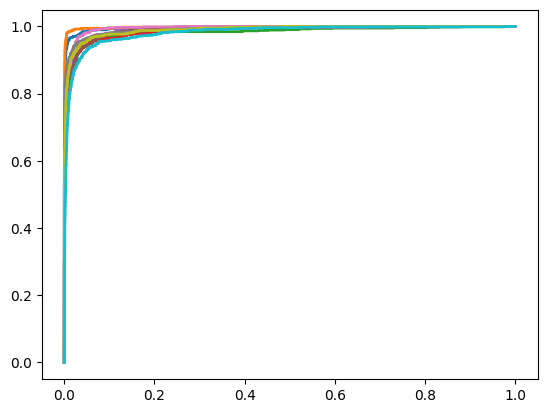

In [26]:
for i in range(10):
        plt.plot(fprs[i], tprs[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, score[i]))

In [21]:
m.Acuracy().calc_metric(y_np_test, y_pred)

0.883452380952381